# ECR Gate calibration with model-free RL (Pulse level simulation)

In this notebook, we will train a reinforcement learning agent to learn pulse level control of a quantum system. The configuration is drawn from two dedicated yaml files respectively describing the quantum environment and the agent. The quantum environment is a `QuantumEnvironment` object, which is a subclass of `gym.Env ` and is designed to be compatible with standard RL libraries. The agent on the other hand, is specifically hard coded for our need because of the need to be able to send to the same resource (the Estimator primitive) a batch of quantum circuits (in contrast with usual RL frameworks where actions can be evaluated in parallel).

For this notebook, we take all necessary inputs from the `ecr_cal_config.py` file. This python file contains all elements necessary to create a pulse-level quantum environment. The file contains the following elements:
- a parametrized gate function, coded through Qiskit; leveraging behind the scenes a custom parametrized pulse schedule, to be inserted in the quantum circuit. The function needs to modify an input parametrized quantum circuit, by appending the parametrized gate to it.
- a Qiskit backend object, which is the quantum device or simulator on which the quantum circuits will be executed. The backend is retrieved through another template function called `get_backend`.
- A circuit context, which is a `QuantumCircuit` object that contains the quantum circuit in which the target gate operation should be optimized. The context is used to create the `ContextAwareQuantumEnvironment` object, which is a subclass of `BaseQuantumEnvironment` that takes into account the context of the quantum circuit in which the gate is to be optimized. Note that this mode is optional, as one could just focus on optimizing the gate operation in a standalone manner (i.e., without any context).

We provide a dedicated template for IBM devices working through ECR, X, and SX basis gates. The user can adapt this to the platform and basis gates of his choice.

For this notebook, we will focus on the calibration of an Echoed Cross Resonance (ECR) gate.

In [1]:
%matplotlib inline
from pulse_level.qiskit_pulse.ecr_calibration.ecr_cal_config import (
    apply_parametrized_circuit,
)
from rl_qoc import ContextAwareQuantumEnvironment, QuantumEnvironment, CustomPPO
from gymnasium.wrappers import RescaleAction, ClipAction
from qiskit.circuit import QuantumCircuit
from rl_qoc.helpers import (
    simulate_pulse_input,
    load_from_yaml_file,
    get_q_env_config,
)
import numpy as np

2024-11-14 16:58:20,583 - qm - INFO     - Starting session: 2b5d626a-88ef-4b73-823e-5722657e3df2


# Quantum Environment Configuration
The quantum environment configuration is drawn from a yaml file. The configuration file contains the following elements:
- Backend information: All the information necessary to retrieve the backend object from Qiskit existing backends (you can also pass your custom backend below).
- Target information: The target to prepare, which can be a quantum gate or a quantum state. The target is described by the name of the gate or the state (e.g., 'x' for the X gate), and the physical qubit indices on which the gate is to be applied.
- Environment information: The hyperparameters of the quantum environment such as:
    - Execution parameters:
        - `N_SHOTS`: The number of shots for the quantum circuit execution
        - `SAMPLING_PAULIS`: The number of Pauli strings to sample for the expectation value estimation
        - `N_REPS`: The number of repetitions of the target operation/circuit context to amplify the noise
        - `BATCH_SIZE`: The number of circuits to be sent to the quantum device in parallel to evaluate the policy
        - `SEED`: The seed for the quantum environment
    - Action space parameters: Specify the parameters range of the action space (i.e. range of pulse parameters)
        - `LOW`: The lower bound of the action space
        - `HIGH`: The upper bound of the action space
    - Reward scheme: The reward scheme to evaluate the performance of the agent
        - `REWARD_METHOD`: The reward method to use. The available options are (`'fidelity'`, `cafe`, `channel`, `state`, `orbit`)
        - `REWARD_PARAMS`: The parameters of the reward method (each reward method has its own parameters)
    - Benchmarking: The benchmarking parameters to evaluate the performance of the agent
        - `BENCHMARK_CYCLE`: The number of updates after which the benchmarking is done
        - `BENCHMARK_BATCH_SIZE`: The number of circuits to be sent to the quantum device in parallel to evaluate the policy during benchmarking
        - `CHECK_ON_EXP`: A flag to indicate if benchmarking should be done through an experiment (such as State/Process Tomography) or through a simulation
                - If `True`, the benchmarking is done through an experiment
                - If `False`, the benchmarking is done through a simulation



In [2]:
# Create custom DynamicsBackend (Pulse level simulator)
from pulse_level.qiskit_pulse.dynamics_backends import (
    fixed_frequency_transmon_backend,
)
from rl_qoc.helpers import (
    perform_standard_calibrations,
    custom_experiment_result_function,
)

print("Custom backend used")
dims = [2, 2]
freqs = [4.86e9, 4.97e9]
anharmonicities = [-0.33e9, -0.32e9]
rabi_freqs = [0.22e9, 0.26e9]
couplings = {(0, 1): 0.002e9}
backend = fixed_frequency_transmon_backend(
    dims,
    freqs,
    anharmonicities,
    rabi_freqs,
    couplings,
    experiment_result_function=custom_experiment_result_function,
)

cals, exps = perform_standard_calibrations(backend)

Custom backend used
Starting Rabi experiment for qubit 0...


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'execution': {'meas_type': 'kerneled'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


2024-11-14 16:58:36 INFO Job data not added for errored job [Job ID: ee70f193-67c0-4e4b-b9c5-940fbea4c63a]
Error message: n/a
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'execution': {'meas_type': 'classified'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


2024-11-14 16:58:38 INFO Job data not added for errored job [Job ID: d18dac3d-83d6-4c90-ae29-7aaa2b2848bd]
Error message: n/a
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'execution': {'meas_type': 'kerneled'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


2024-11-14 16:58:39 INFO Job data not added for errored job [Job ID: 155c6a6c-41fb-46e6-9443-fd20b8ae3528]
Error message: n/a
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'execution': {'meas_type': 'classified'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


2024-11-14 16:58:41 INFO Job data not added for errored job [Job ID: ca7a760f-5a69-4985-8ec7-67bc1dc713e0]
Error message: n/a
Drag experiments done for qubit 1 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'x', 'sx', 's', 'z', 'id', 't', 'reset', 'rz', 'tdg', 'sdg', 'delay', 'h', 'measure'}
  q1: {'x', 'sx', 's', 'z', 'id', 't', 'reset', 'rz', 'tdg', 'sdg', 'delay', 'h', 'measure'}
Multi qubit instructions:
  (0, 1): {'ecr', 'cr45m', 'cr45p'}
  (1, 0): {'ecr', 'cr45m', 'cr45p'}
)>


In [3]:
# Get the quantum environment configuration from yaml file (could also be loaded manually)
import os

current_dir = os.getcwd()
config_file_name = "ecr_pulse_cal.yaml"
# Do not touch part below, just import in your notebook q_env_config and circuit_context
config_file_address = os.path.join(current_dir, config_file_name)

q_env_config = get_q_env_config(
    config_file_address, apply_parametrized_circuit, backend
)
# Add kwargs to the parametrized circuit function
q_env_config.backend_config.parametrized_circuit_kwargs = {
    "target": q_env_config.target,
    "backend": q_env_config.backend,
}

We can define an optional circuit context in which we would like to calibrate the gate.
If the context is not provided, the gate will be calibrated in a standalone manner.

Note: If no context is provided, then the user should use the `QuantumEnvironment` class. Conversely, if a context is provided, the user should use the `ContextAwareQuantumEnvironment` class.

Circuit subject to calibration:


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/visualization/circuit/circuit_visualization.py:353: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  image.show()


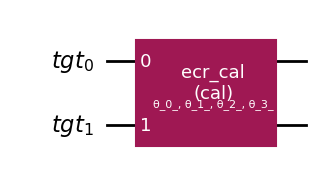

In [4]:
# Set the use_context flag to True if you want to use the context of the quantum circuit
# TODO: Fill up your circuit context
circuit_context = None

if circuit_context is not None:
    fig = circuit_context.draw("mpl", interactive=True)

    q_env = ContextAwareQuantumEnvironment(
        q_env_config, circuit_context, training_steps_per_gate=250
    )

else:
    q_env = QuantumEnvironment(q_env_config)
    fig = q_env.circuits[0].draw("mpl", interactive=True)

# Rescale the action space to [-1, 1] and clip the actions to the valid range
# This step is dependent on the output layer of the agent for the mean of the policy
# If the output layer is a tanh layer (default), then rescaling is necessary

rescaled_env = ClipAction(RescaleAction(q_env, -1, 1))

print("Circuit subject to calibration:")
fig

Template pulse shape for the ECR gate:


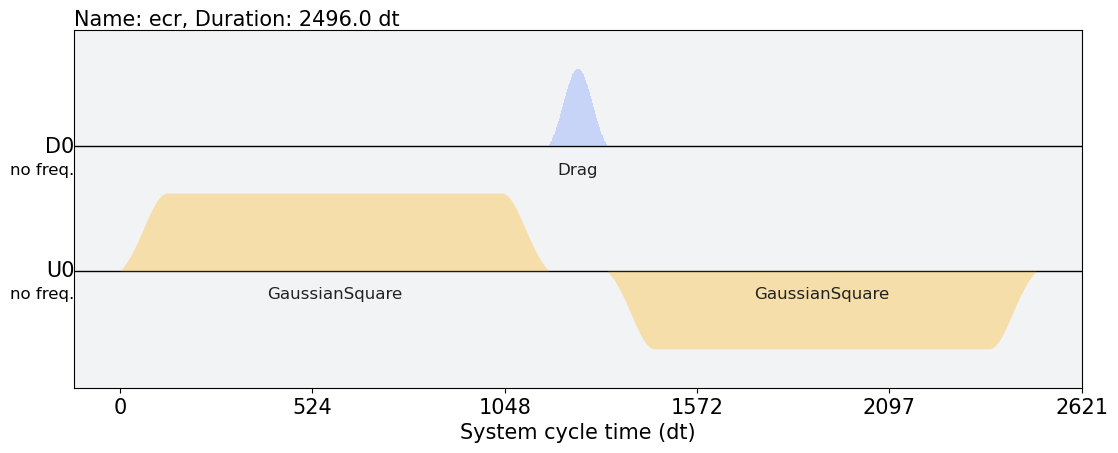

In [5]:
print("Template pulse shape for the ECR gate:")
q_env.backend.target["ecr"][(0, 1)].calibration.draw()

Parametrized pulse:


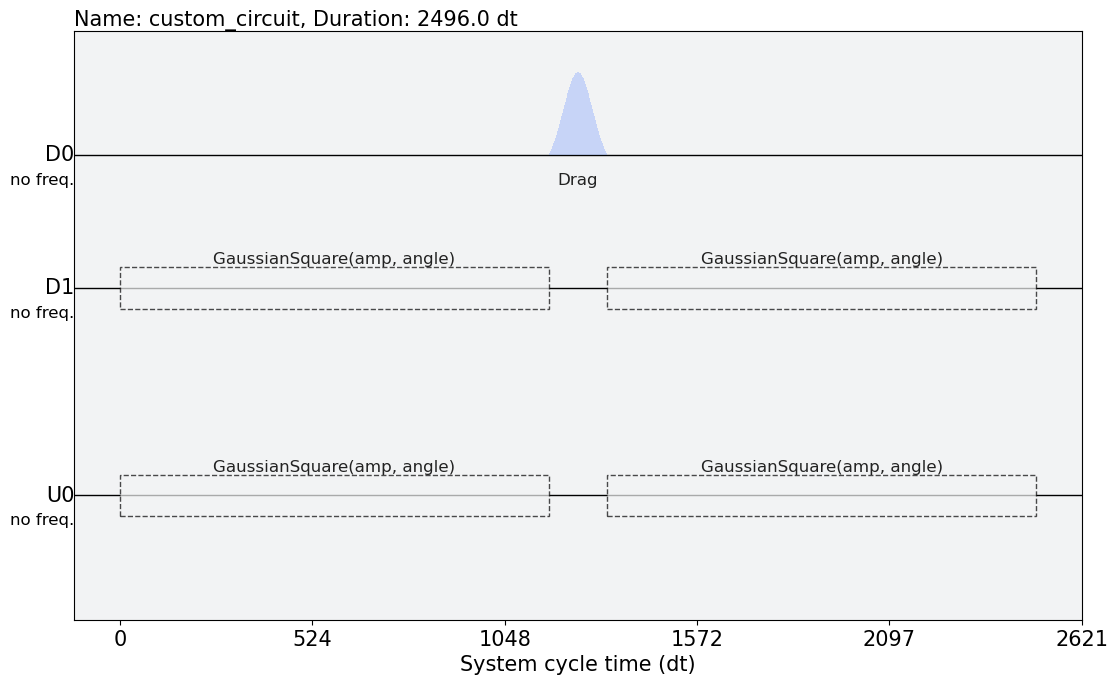

In [6]:
from qiskit import schedule

print("Parametrized pulse:")
schedule(q_env.circuits[0], q_env.backend).draw()

In [7]:
from qiskit.visualization import plot_circuit_layout

print("Available operations", q_env.backend.operation_names)
try:
    plot_circuit_layout(circuit_context, backend=q_env.backend)
except:
    print("No layout available")

Available operations ['measure', 'z', 's', 'sdg', 't', 'tdg', 'rz', 'id', 'h', 'x', 'sx', 'reset', 'delay', 'ecr', 'cr45p', 'cr45m', 'ecr_cal']
No layout available


# Agent setup

We now define the agent counterpart.

In [8]:
from pathlib import Path

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = Path.cwd() / file_name

agent_config = load_from_yaml_file(file_location)

In [9]:
ppo_agent = CustomPPO(agent_config, rescaled_env)

In [10]:
from rl_qoc.agent import TotalUpdates, TrainFunctionSettings, TrainingConfig

total_updates = TotalUpdates(500)
# hardware_runtime = HardwareRuntime(300)
training_config = TrainingConfig(
    training_constraint=total_updates,
    target_fidelities=[0.999, 0.9999],
    lookback_window=10,
    anneal_learning_rate=True,
    std_actions_eps=1e-2,
)

train_function_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=True,
    num_prints=1,
    hpo_mode=False,
    clear_history=True,
)

# Training

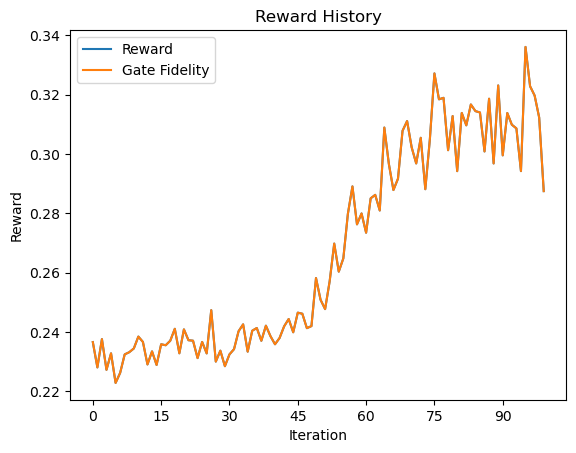

 20%|██        | 100/500 [07:41<30:54,  4.64s/it]

Starting simulation benchmark...


In [ ]:
ppo_agent.train(
    training_config=training_config, train_function_settings=train_function_settings
)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ppo_agent.training_results["std_action"])
plt.xlabel("Updates")
plt.ylabel("Standard Deviation of Actions")
plt.title("Standard Deviation of Actions during Training")

In [ ]:
plt.plot(ppo_agent.training_results["action_history"])
plt.xlabel("Updates")
plt.ylabel("Actions")
plt.title("Actions during Training")

In [ ]:
from rl_qoc import GateTarget

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4
n_epochs = len(mean_rewards)
if q_env.benchmark_cycle != 0:
    fidelity_range = np.arange(0, n_epochs, q_env.benchmark_cycle)
plt.plot(
    # fidelity_range,
    np.array(q_env.fidelity_history),
    label=f"Average {q_env.target.target_type} Fidelity",
)
plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")

plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name if isinstance(q_env.target, GateTarget) else ''} Learning Curve"
)
plt.legend()
plt.show()

In [ ]:
print("Optimal action", q_env.optimal_action)
print("Best fidelity:", np.max(q_env.fidelity_history))

In [ ]:
# Update the gate calibration in the backend target and retrieve the calibration
optimal_calibration = q_env.update_gate_calibration()
q_env.backend.target.get_calibration("ecr", q_env.physical_target_qubits).draw()

# Benchmarking the obtained gate through simulation and tomography

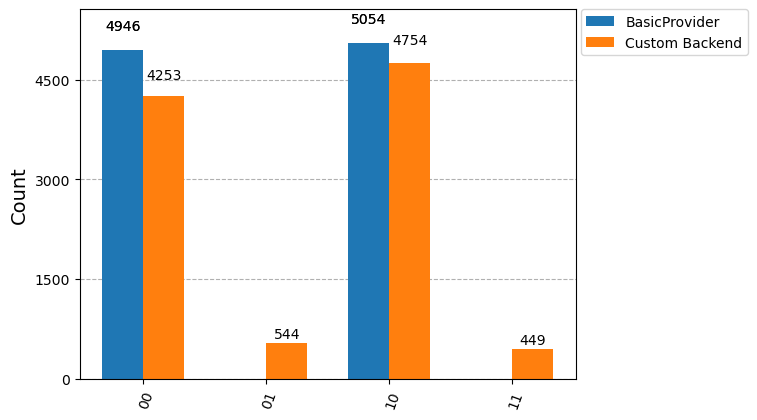

In [10]:
# Testing gate in a quantum circuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

qc = QuantumCircuit(2)
qc.x(0)
qc.h(1)
qc.ecr(0, 1)
qc.measure_all()
qc.draw("mpl")

basic_simulator = BasicSimulator()
basic_result = basic_simulator.run(qc, shots=10000).result()

pulse_circ = transpile(qc, q_env.backend)
q_env.backend.options.shots = 10000
pulse_results = q_env.backend.run(pulse_circ).result()

plot_histogram(
    [basic_result.get_counts(), pulse_results.get_counts()],
    legend=["BasicProvider", "Custom Backend"],
)

In [10]:
# Compute fidelity between ideal and simulated circuit
from qiskit.quantum_info import Statevector, state_fidelity

ideal_state = Statevector(qc.remove_final_measurements(inplace=False))
custom_state = pulse_results.get_statevector()
fidelity = state_fidelity(ideal_state, custom_state)
print("Fidelity between ideal and simulated state:", fidelity)

Fidelity between ideal and simulated state: 0.7821783602783715


In [13]:
from rl_qoc.helpers import fidelity_from_tomography
from qiskit.quantum_info import Operator, Statevector

# Process tomography done through function below
q_env.backend.options.shots = 10000
fidelity = fidelity_from_tomography(
    qc,
    backend,
    q_env.physical_target_qubits,
    Operator(qc.remove_final_measurements(inplace=False)),
)
print("Average Gate Fidelity from tomography: ", fidelity)

Average Gate Fidelity from tomography:  [0.6703716706656533]


In [ ]:
from qiskit_experiments.library.characterization.cr_hamiltonian import (
    EchoedCrossResonanceHamiltonian,
)

cr_ham = EchoedCrossResonanceHamiltonian(q_env.physical_target_qubits, q_env.backend)
cr_ham_data = cr_ham.run().block_for_results()
cr_ham_data.figure(0)
cr_ham.set_experiment_options(
    amp=q_env.optimal_action[0], amp_t=q_env.optimal_action[2]
)
data2 = cr_ham.run().block_for_results()
data2.figure(0)

In [ ]:
from qiskit_experiments.library.randomized_benchmarking import InterleavedRB

rb_exp = InterleavedRB(
    q_env.target.gate,
    q_env.physical_target_qubits,
    np.arange(1, 100, 10),
    q_env.backend,
    num_samples=10,
)
data_rb = rb_exp.run().block_for_results()
data_rb.figure(0)

In [ ]:
from qiskit import schedule

sched = schedule(qc, q_env.backend)
sched.draw()

In [ ]:
from qiskit.transpiler import QubitProperties

v0 = 4.86e9
v1 = 4.97e9
q_env.backend.target.qubit_properties = [
    QubitProperties(frequency=v0),
    QubitProperties(frequency=v1),
]
from qiskit_dynamics.signals import Signal
from qiskit_dynamics.pulse.pulse_to_signals import InstructionToSignals

converter = InstructionToSignals(
    q_env.backend.dt,
    {
        "d0": q_env.backend.qubit_properties(0).frequency,
        "d1": q_env.backend.qubit_properties(1).frequency,
        "u0": q_env.backend.qubit_properties(1).frequency,
    },
    channels=["d0", "d1", "u0"],
)
q_env.simulate_pulse_circuit(q_env.circuits[0], q_env.optimal_action)
dt = q_env.backend.dt
I = np.real(converter.get_signals(sched)[0].samples)
Q = np.imag(converter.get_signals(sched)[0].samples)
t = np.linspace(0, sched.duration * dt, len(I))
plt.plot(t, I)
plt.plot(t, Q)

In [11]:
from qiskit.quantum_info import Statevector

simulate_pulse_input(
    q_env.backend,
    sched,
    target_unitary=Operator(qc.remove_final_measurements(inplace=False)),
    target_state=Statevector(qc.remove_final_measurements(inplace=False)),
)
np.linalg.norm(q_env.backend._dressed_states[:, 0])

TypeError: 'ExperimentData' object is not subscriptable